# Moirai Initial Test
Here we will test the initial setup of the Moirai package.

The first step is to test the installation of the package and the usage of the model
and the data.

## Managing th imports and dependencies
All the necessary imports are done in the following cell. This step will only be performed once and afterward be frozen into the requirements.txt file. For further runs this cell will be commented out. 

In [2]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install torch
# !pip install gluonts
# !pip install huggingface_hub
# !pip freeze > requirements.txt

## Importing the necessary modules
Now where we are sure, that all the dependencies exist locally, we can import the necessary modules.

In [3]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download


from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

## Following the tutorial
The authors of the architecture uploaded a test tutorial in their GitHub repository, we will follow this tutorial closely to get a feel for the usage of the package, the model and the data loader. 

### Setting the static variables
In the tutorials certain variables are set to manage costum settings of the model.

One important setting is the `Size` of the model. The Authors provide three different sizes of the model: `small`, `base` and `large`. The size of the model is determined by the number of parameters.

- small:   XM parameters
- base:   XXM parameters
- large: XXXM parameters

We will use the `small` model for the initial test. The reasoning behind the choice is simply the compute time. The small model is the fastest to train and evaluate. Furthermore, this test is run on a local machine, without any GPU/TPU/NPU acceleration; leading to a CPU-induced performance issue.

Other static are `PREDICTION_LENGTH`, which can be any positive integer and determines the amount of predicted values of the time series. The `CONTEXT_LENGTH` is the amount of values the model uses to predict the next value. 

The `PATCH_SIZE` is the size of the patches the model cuts the prediction data into. The Patch Size is bound to a certain set of values.
- "auto"
- 8
- 16
- 32
- 64
- 128

The `BATCH_SIZE` is the size of the batch the model uses to train the model. The `TEST` variable is the set size of the test data set, the model uses to test the model.

In [88]:
SIZE = "small"
PREDICTION_LENGTH = 100
CONTEXT_LENGTH = 100  
PATCH_SIZE = 40
BATCH_SIZE = 32  
TEST = 120 

### Loading the data
The tutorial suggest to use a particular data set: `https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv` which contains a time series data set. We will first download the data set and inspect it using the gluonts data loader. The data loader suggested by the authors in their tutorial.

In [4]:
url = "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"

We use the pandas data loader to load the data into a python readable format. Before converting it into a gluonts data set.

In [6]:
df = pd.read_csv(url, index_col=0, parse_dates=True)

### Background Pandas Data Frame
The data set contains 10 time series data sets, each with 240 time steps, with a 1 hour interval. 
The data set is a wide data set, which means that the time series are stored in columns and the time steps are stored in rows.

In [9]:
display(df.head())

,A,B,C,D,E,F,G,H,I,J
2021-01-01 00:00:00,-1.3378,0.1268,-0.3645,-1.0864,-2.3803,-0.2447,2.2647,-0.7917,0.7071,1.3763
2021-01-01 01:00:00,-1.6111,0.0926,-0.1364,-1.1613,-2.1421,-0.3477,2.4262,-0.9609,0.6413,1.2750
2021-01-01 02:00:00,-1.9259,-0.1420,0.1063,-1.0405,-2.1426,-0.3271,2.4434,-0.9034,0.4323,0.6767
2021-01-01 03:00:00,-1.9184,-0.4930,0.6269,-0.8531,-1.7060,-0.3088,2.4307,-0.9602,0.3193,0.5150
2021-01-01 04:00:00,-1.9168,-0.5057,0.9419,-0.7666,-1.4287,-0.4284,2.3258,-1.2504,0.3660,0.1708


(240, 10)


In [11]:
print(df.shape)

(240, 10)


### Background GluonTS
The authors explain, the reasoning behind the gluonTS data loader as the data loader of choice, by the fact that it provides very useful functionalities: 
- Splitting the data set into training and test data set
- Performing rolling evaluation
- Converting from pandas data frame to gluonTS data set

We have imported earlier `PandasDataset` and `split` from the gluonTS package. We will use these functionalities to split the data set into training and test data set.

In [13]:
data_set = PandasDataset(dict(df))

PandasDataset<size=10, freq=H, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [89]:
train, test_template = split(
    data_set, offset=-TEST
) 

### Rolling Window Evaluation
The rolling window evaluation is a technique to evaluate the model on a test data set. The model is trained on a training data set and then evaluated on a test data set. The evaluation is done in a rolling window fashion, where the model is evaluated on a set of windows. The windows are in this case non-overlapping (set by the distance between the windows, which in our case is the prediction length). The model is evaluated on each window and the evaluation metrics are the average over all windows.

In [90]:
test_data = test_template.generate_instances(
    prediction_length=PREDICTION_LENGTH,  # number of time steps for each prediction
    windows=TEST // PREDICTION_LENGTH,  # number of windows in rolling window evaluation
    distance=PREDICTION_LENGTH # number of time steps between each window - distance=PDT for non-overlapping windows
)

### Model Initialization
The model now is pulled from HuggingFace. The model is a pre-trained model and will now be  fine-tuned on the training data set.

### The MoiraiForecast Model
The Moirai Model is a transformer architecture, to be precise `moirai` is masked encoder based transformer architecture.

- masked: `masked` TODO
- encoder based: `encoder based` means that the model is based on the transformer encoder architecture and thus has access to all the input at every stage.
- transformer: `transformer` is a deep learning architecture that is based on the attention mechanism. The attention mechanism allows the model to focus on certain parts of the input sequence. The transformer architecture originated and gained popularity in the natural language processing domain.


In [91]:
# Prepare pre-trained model by downloading model weights from huggingface hub
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PREDICTION_LENGTH,
    context_length=CONTEXT_LENGTH,
    patch_size=PATCH_SIZE,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=data_set.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=data_set.num_past_feat_dynamic_real
)

In [92]:
predictor = model.create_predictor(batch_size=BATCH_SIZE)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

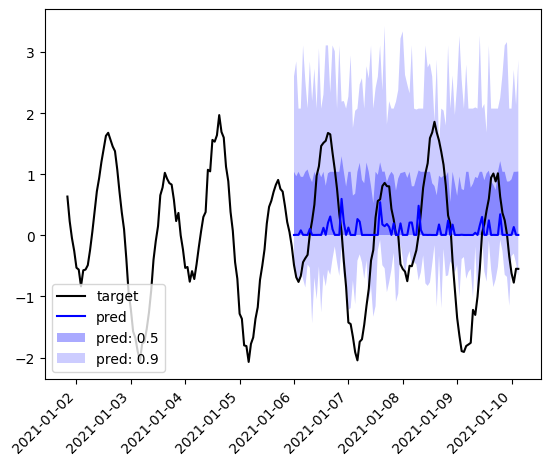

In [93]:
plot_single(
    inp, 
    label, 
    forecast, 
    context_length=100,
    name="pred",
    show_label=True,
)
plt.show()